The code snippets displayed in this tutorial require the following list of extensions and modules.

In [1]:
:ext LambdaCase FlexibleContexts DeriveGeneric OverloadedStrings
:ext ViewPatterns OverloadedLists OverloadedLabels DataKinds
:ext FlexibleInstances ScopedTypeVariables StandaloneDeriving 
:ext NoImplicitPrelude TemplateHaskell DeriveAnyClass 
:ext RecordWildCards QuasiQuotes ParallelListComp RankNTypes

import Protolude
import Text.Pretty.Simple
import System.Random
import Data.List.NonEmpty as NonEmpty hiding (init)
import Refined hiding (NonEmpty)
import Refined.Unsafe
import Data.Sequence as Sequence
import Data.Generics.Product
import Prelude ((!!))
import Data.Maybe (fromJust)
import Data.Coerce
import Data.Generics.Labels
import Data.Functor.Compose
import System.IO hiding (print)
import Control.Monad.Primitive
import Control.Lens
import Bandit
import Bandit.EpsGreedy
import Control.Arrow
import Bandit.Class
import Bandit.Exp3
import Control.Lens
import qualified Data.Text.Lazy.Encoding as T
import qualified Data.Text.Lazy as T
import Data.Generics.Product.Fields
import Data.Aeson hiding ((.=))
import Data.Random.Distribution
import Data.Random
import Graphics.Rendering.Chart
import Graphics.Rendering.Chart.Backend.Cairo
import Graphics.Rendering.Chart.Plot
import Data.Default.Class
import Data.Colour
import Data.Colour.Names
import qualified Data.Vector.Generic as V
import qualified Data.Vector as Ve
import Statistics.Sample
import           System.Directory
import           Data.Default.Class
import           Graphics.Rendering.Chart.Renderable
import           Graphics.Rendering.Chart.Backend.Cairo as BC
import qualified Data.ByteString.Char8 as Char
import           System.IO.Unsafe

import           IHaskell.Display

some code for displaying charts:

In [2]:
myDisplay w h renderable = do
    pngDisp <- chartData w h renderable BC.PNG
    svgDisp <- chartData w h renderable BC.SVG
    return $ Display [pngDisp, svgDisp]
chartData :: Width -> Height -> Renderable a -> FileFormat -> IO DisplayData
chartData width height  renderable format = do
  switchToTmpDir
  let filename = ".ihaskell-chart.png"
      opts = def { _fo_format = format, _fo_size = (width, height) }
  renderableToFile opts filename renderable
  imgData <- Char.readFile filename
  return $
    case format of
      BC.PNG -> png width height $ base64 imgData
      BC.SVG -> svg $ Char.unpack imgData

the non-contextual bandit game:

For $r \in {1,\ldots,T}$  
  $\quad$ Nature selects losses $\ell_{a}^r \in \mathbb{L} \quad \forall a \in \mathbb{A}$  
  $\quad$ The algorithm chooses action $a^r \in \mathbb{A}$  
  $\quad$ The algorithm observes loss $\ell_{a^r}^r \in \mathbb{L}$.  
		
We use the notation $r$ to denote bandit rounds asopposed to the customary use of $t$. Here is some general purpose code used to simulate this process. A game state keeps the history of actions and losses, along with the current bandit state:

In [3]:
data GameState b a l
  = GameState
      { historyActions :: NonEmpty a,
        historyLosses :: Seq l,
        bandit :: b,
        stdGen :: StdGen
      }
  deriving (Generic, Show)

An iteration of the game is a value in the corresponding state monad conditioned on an adversary of type `(a->l)` :

In [4]:
iteration :: (Bandit b hyper a l) => (a->l) -> StateT (GameState b a l) Identity ()
iteration actionToLoss = do
    (actionToLoss . NonEmpty.head -> loss) <- use #historyActions
    oldGen <- use #stdGen
    (action, newGen) <- zoom #bandit $ step oldGen loss
    #stdGen .= newGen
    #historyActions %= (action NonEmpty.<|)
    #historyLosses %= (loss Sequence.<|)

Setup and looping code follows:

In [5]:
runGame adversaries = execState (game adversaries)

game adversaries = for_ adversaries iteration

initialGame ia ib g =  GameState
    { historyActions = [ia],
      historyLosses = [],
      bandit = ib,
      stdGen = g
    }

The `onePass` function takes an hyperparameter, an oblivious deterministic adversary of type `[a->l]`, an initial standard generator and returns the simulation result.

In [6]:
onePass ::
    forall b hyper a l . (Bandit b hyper a l) => 
    hyper ->
    StdGen -> 
    [a->l] -> 
    GameState b a l
onePass hyper g adversaries = runGame adversaries (initialGame initialAction initialBanditState g')
 where
  initialBanditState :: b
  (initialBanditState, initialAction, g') = Bandit.init g hyper

Specializing this to the 'EpsGreedy' datatype on a small toy dataset, using a fixed rate:

In [7]:
let gs = runOnePassEG (mkStdGen 1) 
    f a b = \case True -> a; False -> b
    hyper = EpsGreedyHyper {rateRep = FixedRate 0.5, arms = Bandit.Arms [True, False]}
    runOnePassEG :: StdGen -> GameState (EpsGreedy Bool FixedRate) Bool Double
    runOnePassEG g = onePass hyper g (getZipList $ f <$> ZipList [40, 2, 10] <*> ZipList [4, 44 ,3] )
 in putText $
  "Action series:" <>  show  (historyActions gs ^.. traversed) <>
  "\nLoss series:" <>  show (historyLosses gs ^.. traversed)

Action series:[True,True,False,True]
Loss series:[10.0,44.0,40.0]

We generate gaussian arms for this notebook:

In [8]:
generateGaussianData ::
  Int ->                -- ^ number of rounds
  [ZeroOne Double] ->   -- ^ arm averages
  IO [[Double]]         -- ^ dataset
generateGaussianData ((fromInteger . toInteger) -> n :: Double) avgs =  (mapM generate (unrefine <$> avgs ))
  where
    generate :: (MonadRandom m) => Double -> m [Double]
    generate mu = forM [1..n] $ const $ sample (rvar (Normal mu 0.3))

Line 5: Redundant bracket
Found:
(fromInteger . toInteger)
Why not:
fromInteger . toIntegerLine 5: Redundant bracket
Found:
(mapM generate (unrefine <$> avgs))
Why not:
mapM generate (unrefine <$> avgs)

Plotting:

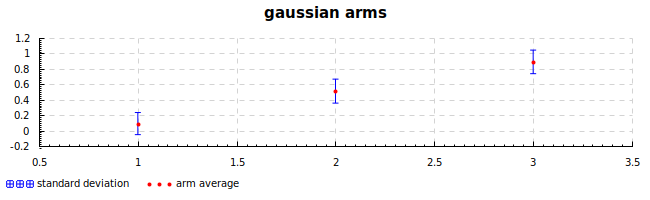

In [9]:
dataset <- generateGaussianData 400 (unsafeRefine <$> [0.1, 0.5, 0.9])

summarizeArms :: [[Double]] -> [(Double, Double, Double)]
summarizeArms arms = [
    (fromInteger . toInteger $ i, 
    mean ((V.fromList a):: Ve.Vector Double),
    stdDev ((V.fromList a)::Ve.Vector Double)) 
    | a <- arms | i <- [1 .. (IHaskellPrelude.length arms)]]

let d :: Text
    d = show $ Protolude.transpose dataset
    
armbars dataset title = toRenderable layout
  where
    vals :: [(Double,Double,Double)]
    vals = summarizeArms dataset
    bars = plot_errbars_values .~ [symErrPoint x y 0 (std/2) | (x,y,std) <- vals]
         $ plot_errbars_title .~"standard deviation"
         $ def
    points = plot_points_style .~ filledCircles 2 (opaque red)
           $ plot_points_values .~ [(x,y) |  (x,y,dx) <- vals]
           $ plot_points_title .~ "arm average"
           $ def
    hidden =
      PlotHidden 
        [ 0.9,
          (fromInteger. toInteger . IHaskellPrelude.length $ dataset) 
           + 0.5] 
        [ 0 ,0 ]
    layout = layout_title .~ title
           $ layout_plots .~ [toPlot bars, toPlot points, toPlot hidden]
           $ def
           
myDisplay 650 200$ toRenderable (armbars dataset "gaussian arms")

Many bandit algorithms require rewards/costs to be in the $\left[ 0,1 \right]$ range, so let's apply a threshold.

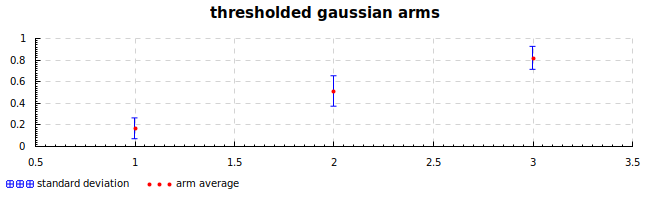

In [10]:
shoveDataset ::  [[Double]] -> [[ZeroOne Double]]
shoveDataset = (fmap.fmap) shove01

shove01 :: Double -> ZeroOne Double
shove01 x
    | x < 0 = Bandit.zero
    | x > 1 = Bandit.one
    | otherwise = unsafeRefine x
shoved = shoveDataset dataset

myDisplay 650 200 $ toRenderable $ armbars ((fmap.fmap) unrefine shoved) "thresholded gaussian arms"

This helper converts this dataset to the `[action->loss]` oblivious deterministic adversary format.

In [11]:
toAdversary :: [[a]] -> [Int -> a]
toAdversary xss = Protolude.transpose xss <&> listToAdversary
 where
  listToAdversary :: [a] -> Int -> a
  listToAdversary l i = l Prelude.!! i

We define some experiments.

In [12]:
exp3 :: [[Double]] -> StdGen -> GameState (Exp3 Int) Int (ZeroOne Double)
exp3 dataset g = 
  onePass (Bandit.Arms [0..2]) g (toAdversary $ shoveDataset dataset)
                 
greedy :: (Rate r) => [[Double]] -> StdGen -> r -> GameState (EpsGreedy Int r) Int Double
greedy dataset g r =  
  onePass (EpsGreedyHyper {rateRep = r, arms = Bandit.Arms [0..2]}) g (toAdversary dataset)

We generate multiple datasets and run those experiments. 

In [13]:
data SimResult t v =
  SimResult {
    t :: t Int,
    seed :: t Int,
    greedy05 :: t v,
    greedy03 :: t v,
    greedysqrt05 :: t v,
    exp3pf :: t v
  } deriving (Generic)
  
simulation :: Int -> Int -> IO (SimResult [] Double)
simulation tmax seed@(mkStdGen -> g) = do
  dataset <- (fmap.fmap) unrefine . shoveDataset <$> generateGaussianData tmax (unsafeRefine <$> [0.1, 0.5, 0.9])
  return $ SimResult {
               t = [1 .. tmax],
               seed = Protolude.replicate tmax seed,
               greedy05 = extract $ greedy dataset g (FixedRate 0.5),
               greedy03 = extract $ greedy dataset g (FixedRate 0.3),
               greedysqrt05 = extract $ greedy dataset g (InverseSqrtRate 0.5),
               exp3pf = fmap unrefine . extract $ exp3 dataset g
            }
 where
   extract = Protolude.toList . Sequence.reverse . historyLosses

Code for calculating statistics on experiments:

In [14]:
results :: [SimResult [] Double] <- forM ([1..10] ::[Int]) (simulation 600)
type Stats = (Double,Double,Double,Double,Double,Double,Double,Double)

data ExpeResult t =
    ExpeResult {
    tr :: t Int,
    greedy05r :: t Stats,
    greedy03r :: t Stats,
    greedysqrt05r :: t Stats,
    exp3pfr :: t Stats
    } deriving (Generic)

summarizeExperiments :: [ SimResult [] Double ] -> ExpeResult []
summarizeExperiments resultList = ExpeResult {
            tr = t (fromJust $ Protolude.head resultList),
            greedy05r     = toAllStats greedy05,
            greedy03r     = toAllStats greedy03,
            greedysqrt05r = toAllStats greedysqrt05,
            exp3pfr       = toAllStats exp3pf
        }
  where
    toAllStats accessor = [(x,y,z,z',a,b,c,d)|(x,y,z,z') <- expesToStats accessor | (a,b,c,d) <- expesToCumulativeStats accessor]
    expesToStats accessor = mkStats <$> (Protolude.transpose $ accessor <$> resultList)
    expesToCumulativeStats accessor = mkStats <$> (Protolude.transpose $ cumsum . accessor <$> resultList) 
    cumsum :: [Double] -> [Double]
    cumsum x = [sum (IHaskellPrelude.take k x) - (fromIntegral k * 0.1 ) | k <- [1.. IHaskellPrelude.length x]]
    mkStats :: [Double] -> (Double,Double,Double,Double)
    mkStats xs = (mean (Ve.fromList xs), stdDev (Ve.fromList xs), minimum xs,maximum xs)

summarized :: ExpeResult []
summarized = summarizeExperiments results

mkTS :: (Stats -> a) -> ExpeResult [] -> (ExpeResult [] -> [Stats]) -> [(Int,a)]
mkTS viewer er accessor =  [ (t,viewer x) | t <- tr er | x <- accessor er]

v = view 
getAveragesTS  = mkTS (v _1)
getCumulativeTS = mkTS (v _5)
getCumulativeMinMaxTS = mkTS (v _7 &&& v _8)
getCumulativeUpperStdBound = mkTS (\x-> v _5 x + (v _6 x / 2.0))
getCumulativeLowerStdBound = mkTS (\x -> v _5 x - (v _6 x / 2.0))

Plotting the regret for various algorithms, along with standard deviation(dashed lines) and best/worst experiment (area): 

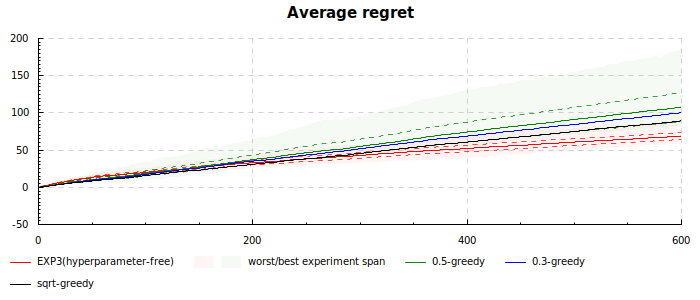

In [15]:
compareSimulations :: ExpeResult [] -> Layout Int Double 
compareSimulations er = layout
  where
    area ts col = plot_fillbetween_style  .~ solidFillStyle (withOpacity col 0.04)
           $ plot_fillbetween_values .~ ts
           $ plot_fillbetween_title  .~ "worst/best experiment span"
           $ def
    value ts col name = plot_lines_style . line_color .~ opaque col
           $ plot_lines_values .~ [ts]
           $ plot_lines_title .~ name
           $ def
    dashed ts col = plot_lines_values .~ [ts]
           $ plot_lines_style .~ dashedLine 0.7 [5,5] (withOpacity col 1)
           
           $ def
    fullCurve :: (ExpeResult [] -> [Stats]) -> Colour Double -> IHaskellPrelude.String -> [Plot Int Double]
    fullCurve accessor col name = [toPlot (value (getCumulativeTS er accessor) col name),
                                  toPlot (area (getCumulativeMinMaxTS er accessor) col),
                                  toPlot (dashed (getCumulativeUpperStdBound er accessor) col),
                                  toPlot (dashed (getCumulativeLowerStdBound er accessor) col)]
    oneCurve :: (ExpeResult [] -> [Stats]) -> Colour Double -> IHaskellPrelude.String -> [Plot Int Double]
    oneCurve accessor col name = [toPlot (value (getCumulativeTS er accessor) col name)]
    layout = layout_title .~"Average regret"
           $ layout_plots .~  fullCurve exp3pfr red "EXP3(hyperparameter-free)"
                           <> fullCurve greedy05r green "0.5-greedy" 
                           <> oneCurve greedy03r blue "0.3-greedy"
                           <> oneCurve greedysqrt05r black "sqrt-greedy"
           $ def
           
myDisplay 700 300 $ toRenderable $ compareSimulations summarized